# StarCMM+ Data Analysis #

Data analysis of StarCCM+ used for validation purposes. 

Test case parameters:

<b> Dimensions:<b/>
- Pipe Radius $R_t = 1$ mm 
- Pipe Length $L = 0.1$ m
    
<b> Boundary Conditions:<b/>
- No slip wall condition
- 1600 K at inlet, outlet, and walls (isothermal wall)
- Segregated Fluid Enthalpy

## Laminar Flow through pipe ## 

- 20 m/s inlet (velocity inlet stagnation inlet currently not working)
- Pressure Outlet

### Data Preprocessing ### 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def preprocess(xfile, yfile):
    x_raw = pd.read_csv('starccm_data/' + xfile)
    y_raw = pd.read_csv('starccm_data/' + yfile)

    x_raw.columns = ['x', 'var']
    y_raw.columns = ['y', 'var']
    
    data = pd.merge(x_raw, y_raw, on='var')
    data = data[['x','y','var']]
    data.sort_values(by=['x', 'y'], inplace=True)
    
    xx, yy = np.meshgrid(data.x.unique(), data.y.unique())
    zz = np.zeros(xx.shape)
    
    for i, x in enumerate(xx[0]):
        zz[:,i] = np.array(data[data.x==x].drop_duplicates(subset=['y'])['var'])
        
    return xx, yy, zz

In [3]:
xx, yy, zz = preprocess('direction_x.csv', 'direction_y.csv')

### Analysis ### 

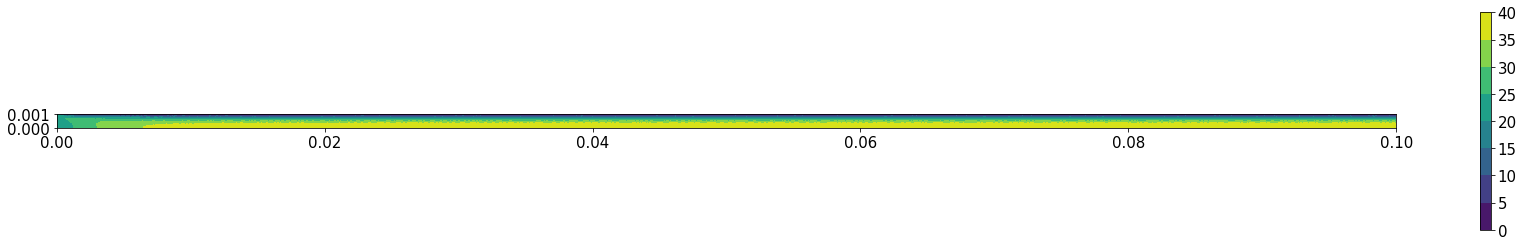

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4))
plt.contourf(xx, yy, zz)
plt.axis('scaled')
plt.colorbar()
plt.show()

### Comparison to Analytical Solution ###

Using the <b> Hagen-Poisseuille Law <b/>
    
$$ u_z(r) = -\frac{dp}{dz} \left( \frac{R^2-r^2}{4 \mu}\right) $$
    
Using:
    $$ \frac{dp}{dz} \sim \frac{\Delta p}{L} = 128 \frac{\mu L Q}{\pi d^4} $$ 
    
Where $L$ is the length of the pipe, $Q$ is the volumentric flow rate, and $d$ is the diameter of the pipe. Assuming incompressible flow, $Q = uA = u\pi r^2$.
    
At T = 1600 K, $\mu = 5.457 \times 10^{-5} \: \mathrm{kg \:m^{-1}s^{-1}}$.
    
Substituting gives $\Delta p / L = -8731.2 \: \mathrm{Pa \: m^{-1}}$
    
Sources:
    
https://kparker.bg-research.cc.ic.ac.uk/homepage/Mechanics%20of%20the%20Circulation/Chap_05/_Chapter_05.htm
    
https://www.engineeringtoolbox.com/dry-air-properties-d_973.html

In [5]:
R = 0.001 # m
L = 0.1 # m
dpdz = -8731.2 # Pa m-1
mu = 5.457e-5
u_analytical = -dpdz * (R**2 - yy[:,0]**2)/(4*mu)

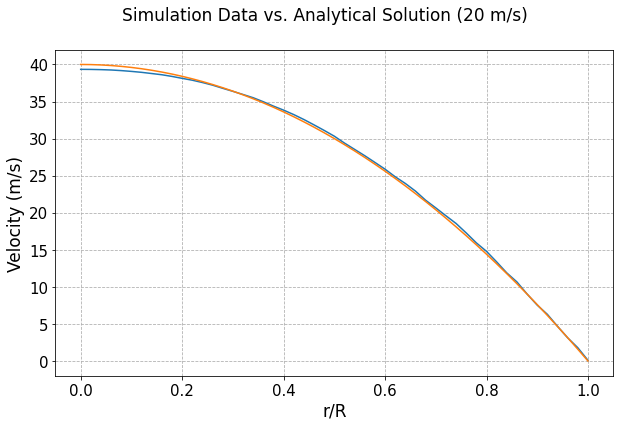

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(yy[:,0]/R, zz[:,-1])
ax.plot(yy[:,0]/R, u_analytical)
ax.grid(visible=True, which='major', linestyle='--')
ax.set_xlabel('r/R')
ax.set_ylabel('Velocity (m/s)')
fig.suptitle('Simulation Data vs. Analytical Solution (20 m/s)')
plt.show()

### Temperature Gradient ###

In [7]:
xx, yy, temp = preprocess('xgrid_temp.csv', 'ygrid_temp.csv')
xx, yy, rho = preprocess('xgrid_density.csv', 'ygrid_density.csv')
xx, yy, u = preprocess('xgrid_vel.csv', 'ygrid_vel.csv')
xx, yy, p = preprocess('xgrid_press.csv', 'ygrid_press.csv')

In [32]:
# Taking average along tube

x = xx[0,:]

t_bar = np.mean(temp, axis=0)
rho_bar = np.mean(rho, axis=0)
u_bar = np.mean(u, axis=0)
p_bar = np.mean(p, axis=0) + 101325

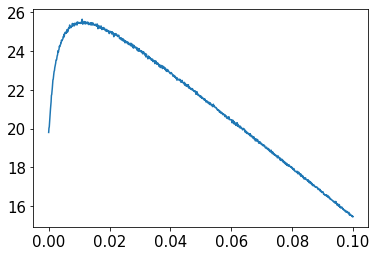

In [33]:
plt.plot(x, u_bar)
plt.show()

In [34]:
x = x[200:] - x[200]
t_bar = t_bar[200:]
rho_bar = rho_bar[200:]
u_bar = u_bar[200:]
p_bar = p_bar[200:] 

By observation, taking points from 0.02 m onwards. 

In [35]:
c = np.sqrt(1.4*287*t_bar)

In [21]:
M = u_bar/c

In [17]:
from model import TemperatureGradientModel

In [36]:
analytical = TemperatureGradientModel(x[-1]-x[0], 0, 800, p_bar[0], M[0], t_bar[0], t_bar[-1])
analytical.calculate()

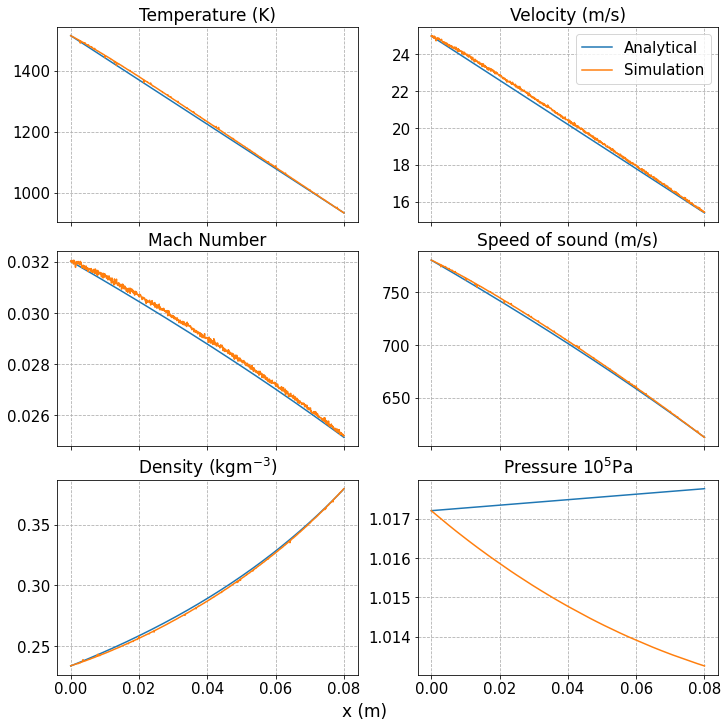

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (10, 10), constrained_layout=True, sharex=True)
ax[0][0].plot(analytical.x, analytical.T)
ax[0][1].plot(analytical.x, analytical.u)
ax[1][0].plot(analytical.x, analytical.M)
ax[1][1].plot(analytical.x, analytical.c)
ax[2][0].plot(analytical.x, analytical.rho)
ax[2][1].plot(analytical.x, analytical.p/100000)

ax[0][0].plot(x, t_bar)
ax[0][1].plot(x, u_bar)
ax[1][0].plot(x, M)
ax[1][1].plot(x, c)
ax[2][0].plot(x, rho_bar)
ax[2][1].plot(x, p_bar/100000)


ax[0][0].set_title('Temperature (K)')
ax[0][1].set_title('Velocity (m/s)')
ax[1][0].set_title('Mach Number')
ax[1][1].set_title('Speed of sound (m/s)')
ax[2][0].set_title(r'Density ($\mathrm{kgm^{-3}}$)')
ax[2][1].set_title(r'Pressure $10^{5} \mathrm{Pa}$')

ax[0][1].legend(['Analytical', 'Simulation'])

for axes in ax.flat:
    axes.grid(visible=True, which='major', linestyle='--')
fig.supxlabel('x (m)')
fig.show()